In [2]:
EEG_channels = 22 #from project guidelines
test_count = 50 #from project guideline, 238 for train-validation and 50 for test
validation_count = 38 # 38 points in validation set and remaining 200 points in test set

In [3]:
from includes import *

#################### "includes" imports:
#
#   from read_data import *
#   
#   import torch
#   from torch.autograd import Variable
#   import torch.nn as nn
#   import torch.optim as optim
#
#   dtype = torch.cuda.FloatTensor # torch.FloatTensor
#
#   all_files = [h5py.File(m, 'r') for m in mat_names]
#   all_ims = [f['image'] for f in all_files]
#   all_types = [f['type'] for f in all_files]
#
####################
%load_ext autoreload
%autoreload 2

In [4]:
image_mat = all_ims[0]
image_shape = image_mat.shape # 288 (48x6) trials across 25 electrodes for 1000 time points (250Hz*4s)
print image_shape

(288, 25, 1000)


In [5]:
print(mat_names)

['./project_datasets/A01T_slice.mat', './project_datasets/A02T_slice.mat', './project_datasets/A03T_slice.mat', './project_datasets/A04T_slice.mat', './project_datasets/A05T_slice.mat', './project_datasets/A06T_slice.mat', './project_datasets/A07T_slice.mat', './project_datasets/A08T_slice.mat', './project_datasets/A09T_slice.mat']


In [6]:
#setting seed
np.random.seed(seed=1337)
test_picked = np.random.choice(image_shape[0], test_count, replace=False)
train_val_picked = np.setdiff1d(np.arange(image_shape[0]), test_picked)
val_picked = train_val_picked[:validation_count]
train_picked = train_val_picked[validation_count:]

In [7]:
type_mat = all_types[0]
type_shape = type_mat.shape
type_set = list(set(type_mat[0,:]))

# all the 0's occur after 288, and are meaningless I think
# so the image_mat, which has shape (288, 25, 1000) should correspond
# to the first 288 entries of type_mat, so
# for a single subject, training data should be image_mat, with 288 samples, each sample has shape (25, 1000)
# and our target label matrix should be type_mat[:288] (or 287?)

In [8]:
trainval_data_X = []
training_data_X = []
validation_data_X = []
test_data_X = []

trainval_data_Y = []
training_data_Y = []
validation_data_Y = []
test_data_Y = []

for i in range(len(mat_names)):
    matfile = h5py.File(mat_names[i], 'r')
    
    trainval_data_X.append(matfile['image'][sorted(train_val_picked),:EEG_channels,:]) #(238, 22, 1000) x 9
    training_data_X.append(matfile['image'][sorted(train_picked),:EEG_channels,:]) #(200, 22, 1000) x 9
    validation_data_X.append(matfile['image'][sorted(val_picked),:EEG_channels,:]) #(38, 22, 1000) x 9
    test_data_X.append(matfile['image'][sorted(test_picked),:EEG_channels,:]) #(50, 22, 1000) x 9
    
    trainval_data_Y.append(matfile['type'][0,sorted(train_val_picked)] - type_set[1]) #(238, ) x 9
    training_data_Y.append(matfile['type'][0,sorted(train_picked)] - type_set[1]) #(200, ) x 9
    validation_data_Y.append(matfile['type'][0,sorted(val_picked)] - type_set[1]) #(38, ) x 9
    test_data_Y.append(matfile['type'][0,sorted(test_picked)] - type_set[1]) #(50, ) x 9

In [9]:
for i in range(len(mat_names)):
    assert(set(training_data_Y[i]) == set(validation_data_Y[i])) #check whether we have data for all labels 
    assert(set(training_data_Y[i]) == set(test_data_Y[i])) #check whether we have data for all labels 

In [10]:
from functools import reduce

rnn_trainval_data_X = np.concatenate(trainval_data_X, axis=0) #(2142, 22, 1000)
rnn_training_data_X = np.concatenate(training_data_X, axis=0) #(1800, 22, 1000)
rnn_validation_data_X = np.concatenate(validation_data_X, axis=0) #(342, 22, 1000)
rnn_test_data_X = np.concatenate(test_data_X, axis=0) #(450, 22, 1000)

rnn_trainval_data_Y = np.concatenate(trainval_data_Y, axis=0) #(2142, )
rnn_training_data_Y = np.concatenate(training_data_Y, axis=0) #(1800, )
rnn_validation_data_Y = np.concatenate(validation_data_Y, axis=0) #(342, )
rnn_test_data_Y = np.concatenate(test_data_Y, axis=0) #(450,)

def remove_nan_rows_A(A, b, debug=True):
    if (debug):
        print('before nans: {}'.format(str(A.shape)))
    if (np.isnan(A).any() or np.isnan(b).any()):
        mask = ~np.isnan(np.sum(A,axis=(1,2))) & ~np.isnan(b[:])
        A = A[mask, :, :]
        b = b[mask]
    
    if (debug):
        print('before nans: {}'.format(str(A.shape)))
    assert A.shape[0] == b.shape[0]
    return A, b

rnn_trainval_data_X, rnn_trainval_data_Y = remove_nan_rows_A(rnn_trainval_data_X,
                                                             rnn_trainval_data_Y)
rnn_training_data_X, rnn_training_data_Y = remove_nan_rows_A(rnn_training_data_X, 
                                                             rnn_training_data_Y)
rnn_validation_data_X, rnn_validation_data_Y = remove_nan_rows_A(rnn_validation_data_X,
                                         rnn_validation_data_Y)
rnn_test_data_X, rnn_test_data_Y = remove_nan_rows_A(rnn_test_data_X,
                                   rnn_test_data_Y)

N_trainval, E, T = rnn_trainval_data_X.shape
N_training, _, _ = rnn_trainval_data_X.shape
N_validation, _, _ = rnn_test_data_X.shape
N_test, _, _ = rnn_test_data_X.shape

before nans: (2142, 22, 1000)
before nans: (2115, 22, 1000)
before nans: (1800, 22, 1000)
before nans: (1775, 22, 1000)
before nans: (342, 22, 1000)
before nans: (340, 22, 1000)
before nans: (450, 22, 1000)
before nans: (443, 22, 1000)


In [11]:
print(training_data_Y[0].shape)

(200,)


In [12]:
training_data_shape = training_data_X[0].shape
print(training_data_shape) #(200, 22, 1000) while test data shape is (50, 22, 1000) and validation data is (38, 22,1000)

(200, 22, 1000)


In [13]:
print rnn_trainval_data_X.shape
print rnn_trainval_data_Y.shape

(2115, 22, 1000)
(2115,)


In [14]:
from torch.nn.utils.rnn import pack_padded_sequence as ppseq

In [15]:
tensor_x_train = torch.Tensor(rnn_training_data_X)
tensor_y_train = torch.LongTensor(rnn_training_data_Y)

print tensor_x_train.shape
print tensor_y_train.shape

tensor_x_val = torch.Tensor(rnn_validation_data_X)
tensor_y_val = torch.LongTensor(rnn_validation_data_Y)

torch.Size([1775, 22, 1000])
torch.Size([1775])


In [16]:
import torch.utils.data

In [82]:
# Dataset Hyper Parameters
num_epochs = 30
batch_size = 100

In [83]:
train_dataset = torch.utils.data.TensorDataset(tensor_x_train,tensor_y_train)
val_dataset = torch.utils.data.TensorDataset(tensor_x_val,tensor_y_val)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size, 
                                           shuffle=True)

val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                          batch_size=batch_size, 
                                          shuffle=False)

In [114]:
# Optimizer Hyper Parameters
learning_rate = 1e-3
reg_hidden_weight = 1.0
reg_weight_size = 0.01
NUM_CLASSES = 4

# Debug Parameters
VERBOSE = False
PRINT_GRADS = False

from VanillaRNN import VanillaRNN

net = VanillaRNN(
                conv_layers = True,
                initial_hidden_layer_sizes = [],#[100],#[100],
                recurrent_hidden_size = 32,
                recurrent_use_bias = True,
                recurrent_layer_num = 2,
                #recurrent_dropout = 0.25,
                final_hidden_layer_sizes = [],#[8*36],#[100, 10],
                num_classes=NUM_CLASSES,
                verbose = VERBOSE)

FCC_SANITY = True

#from FC import FC
#net = FC()
#FCC_SANITY = True

net.initialize_weights()

criterion = nn.CrossEntropyLoss()
#optimizer = torch.optim.RMSprop(net.parameters(), lr=learning_rate)
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)#, weight_decay=0.01)


#optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, nesterov=True)


for s in net.parameters():
    print('{}'.format(s.shape))
    

torch.Size([22])
torch.Size([22])
torch.Size([16, 22, 25])
torch.Size([16])
torch.Size([8, 16, 25])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([288])
torch.Size([288])
torch.Size([4, 288])
torch.Size([4])


torch.Size([1775, 4])


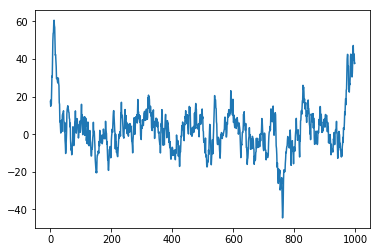

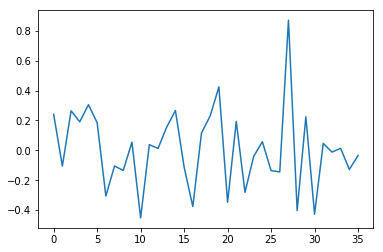

In [115]:
net.train(True)

if (FCC_SANITY):
    out = net.forward(tensor_x_train)
else:
    out, hidden = net.forward(tensor_x_train)
print(out.shape)
net.train(False)

if (FCC_SANITY):
    out = net.forward(tensor_x_train)
else:    
    out, hidden = net.forward(tensor_x_train)
    
#print(net.rnn_out.shape)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:63: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:64: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:65: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch [1/30], Iter [1/17] Loss: [----- 1.3982 = 1.3982 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [1/30], Iter [2/17] Loss: [----- 1.4046 = 1.4046 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [1/30], Iter [3/17] Loss: [----- 1.4138 = 1.4138 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [1/30], Iter [4/17] Loss: [----- 1.4434 = 1.4434 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [1/30], Iter [5/17] Loss: [----- 1.4906 = 1.4906 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [1/30], Iter [6/17] Loss: [----- 1.4096 = 1.4096 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [1/30], Iter [7/17] Loss: [----- 1.4039 = 1.4039 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [1/30], Iter [8/17] Loss: [----- 1.4221 = 1.4221 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [1/30], Iter [9/17] Loss: [----- 1.3951 = 1.3951 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [1/30], Iter [10/17] Loss: [----- 1.3803 = 1.3803 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [1/30], Iter [11/17] Loss: [----- 1.3569 = 

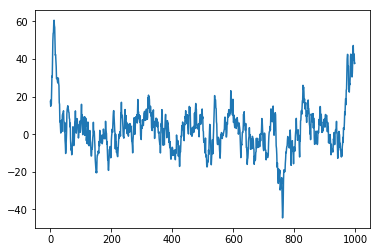

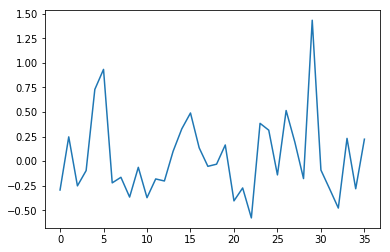

torch.Size([1775, 4])
Train Accuracy: 39 %


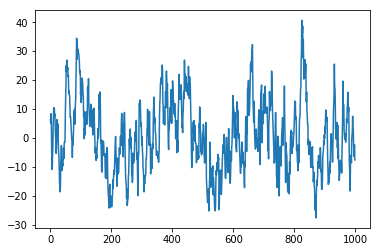

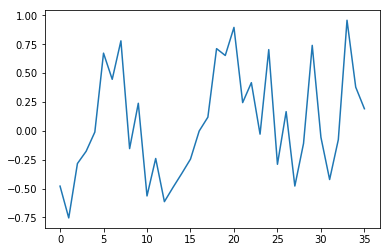

predicted set [0 1 2 3]
label set [0 1 2 3]
validation Accuracy: 35 %
Epoch [2/30], Iter [1/17] Loss: [----- 1.3329 = 1.3329 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [2/30], Iter [2/17] Loss: [----- 1.2505 = 1.2505 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [2/30], Iter [3/17] Loss: [----- 1.3078 = 1.3078 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [2/30], Iter [4/17] Loss: [----- 1.2878 = 1.2878 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [2/30], Iter [5/17] Loss: [----- 1.2815 = 1.2815 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [2/30], Iter [6/17] Loss: [----- 1.2888 = 1.2888 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [2/30], Iter [7/17] Loss: [----- 1.2971 = 1.2971 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [2/30], Iter [8/17] Loss: [----- 1.2867 = 1.2867 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [2/30], Iter [9/17] Loss: [----- 1.2414 = 1.2414 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [2/30], Iter [10/17] Loss: [----- 1.3716 = 1.3716 + 1.00 * 1.6046 + 0

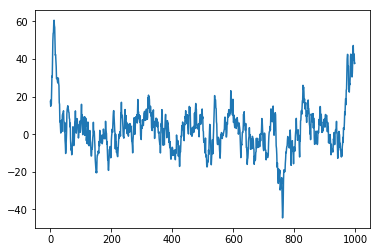

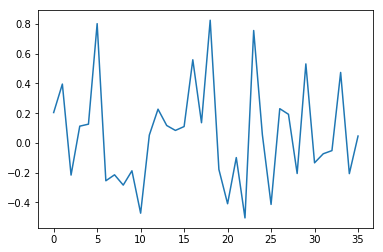

torch.Size([1775, 4])
Train Accuracy: 44 %


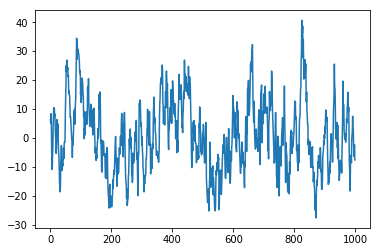

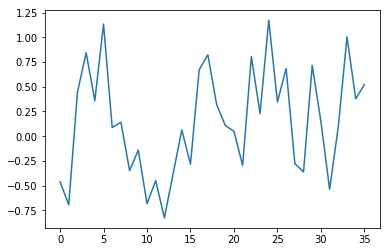

predicted set [0 1 2 3]
label set [0 1 2 3]
validation Accuracy: 38 %
Epoch [3/30], Iter [1/17] Loss: [----- 1.2191 = 1.2191 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [3/30], Iter [2/17] Loss: [----- 1.1932 = 1.1932 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [3/30], Iter [3/17] Loss: [----- 1.2958 = 1.2958 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [3/30], Iter [4/17] Loss: [----- 1.2527 = 1.2527 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [3/30], Iter [5/17] Loss: [----- 1.1894 = 1.1894 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [3/30], Iter [6/17] Loss: [----- 1.2755 = 1.2755 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [3/30], Iter [7/17] Loss: [----- 1.2880 = 1.2880 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [3/30], Iter [8/17] Loss: [----- 1.1993 = 1.1993 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [3/30], Iter [9/17] Loss: [----- 1.2377 = 1.2377 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [3/30], Iter [10/17] Loss: [----- 1.1783 = 1.1783 + 1.00 * 1.6046 + 0

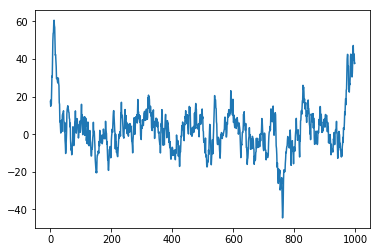

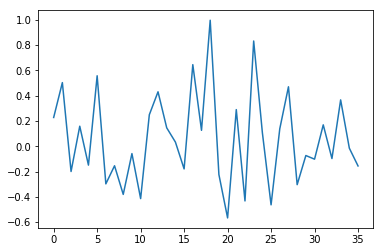

torch.Size([1775, 4])
Train Accuracy: 51 %


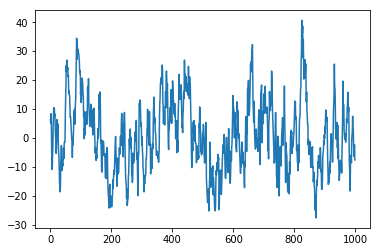

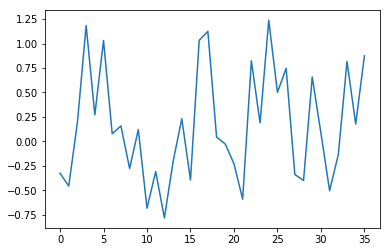

predicted set [0 1 2 3]
label set [0 1 2 3]
validation Accuracy: 42 %
Epoch [4/30], Iter [1/17] Loss: [----- 1.0796 = 1.0796 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [4/30], Iter [2/17] Loss: [----- 1.1932 = 1.1932 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [4/30], Iter [3/17] Loss: [----- 1.1595 = 1.1595 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [4/30], Iter [4/17] Loss: [----- 1.2174 = 1.2174 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [4/30], Iter [5/17] Loss: [----- 1.1320 = 1.1320 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [4/30], Iter [6/17] Loss: [----- 1.0454 = 1.0454 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [4/30], Iter [7/17] Loss: [----- 1.1211 = 1.1211 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [4/30], Iter [8/17] Loss: [----- 1.2054 = 1.2054 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [4/30], Iter [9/17] Loss: [----- 1.1249 = 1.1249 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [4/30], Iter [10/17] Loss: [----- 1.1422 = 1.1422 + 1.00 * 1.6046 + 0

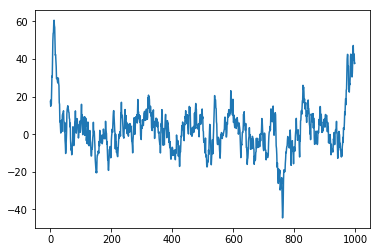

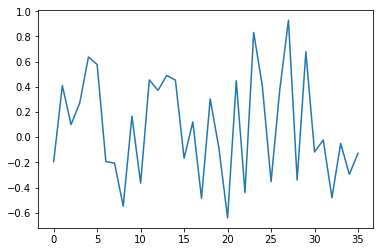

torch.Size([1775, 4])
Train Accuracy: 54 %


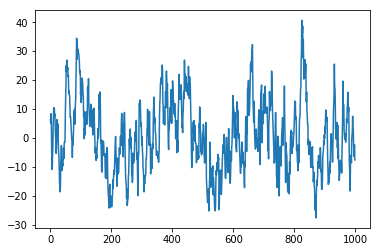

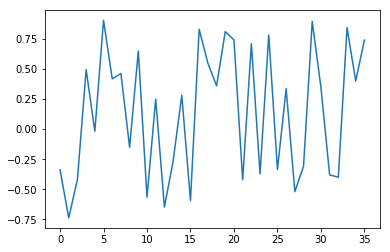

predicted set [0 1 2 3]
label set [0 1 2 3]
validation Accuracy: 46 %
Epoch [5/30], Iter [1/17] Loss: [----- 1.0234 = 1.0234 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [5/30], Iter [2/17] Loss: [----- 1.1160 = 1.1160 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [5/30], Iter [3/17] Loss: [----- 1.1129 = 1.1129 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [5/30], Iter [4/17] Loss: [----- 1.0745 = 1.0745 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [5/30], Iter [5/17] Loss: [----- 1.0674 = 1.0674 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [5/30], Iter [6/17] Loss: [----- 1.1091 = 1.1091 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [5/30], Iter [7/17] Loss: [----- 1.0412 = 1.0412 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [5/30], Iter [8/17] Loss: [----- 1.1182 = 1.1182 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [5/30], Iter [9/17] Loss: [----- 1.0736 = 1.0736 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [5/30], Iter [10/17] Loss: [----- 1.1251 = 1.1251 + 1.00 * 1.6046 + 0

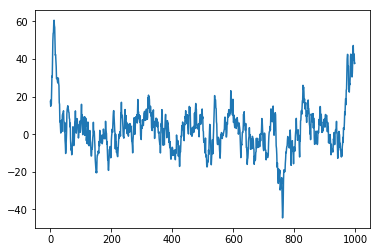

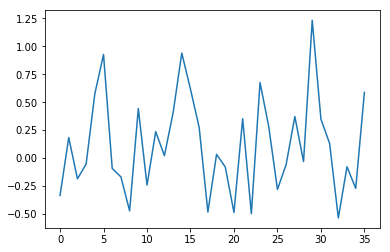

torch.Size([1775, 4])
Train Accuracy: 58 %


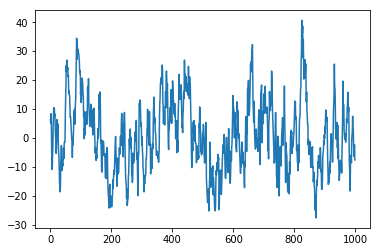

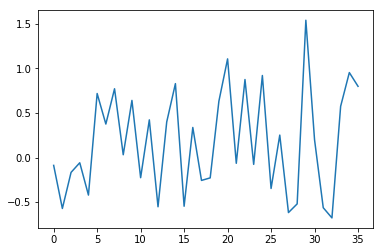

predicted set [0 1 2 3]
label set [0 1 2 3]
validation Accuracy: 49 %
Epoch [6/30], Iter [1/17] Loss: [----- 0.9972 = 0.9972 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [6/30], Iter [2/17] Loss: [----- 1.0746 = 1.0746 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [6/30], Iter [3/17] Loss: [----- 1.0926 = 1.0926 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [6/30], Iter [4/17] Loss: [----- 1.0002 = 1.0002 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [6/30], Iter [5/17] Loss: [----- 1.0201 = 1.0201 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [6/30], Iter [6/17] Loss: [----- 1.0787 = 1.0787 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [6/30], Iter [7/17] Loss: [----- 1.0596 = 1.0596 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [6/30], Iter [8/17] Loss: [----- 1.0885 = 1.0885 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [6/30], Iter [9/17] Loss: [----- 1.1418 = 1.1418 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [6/30], Iter [10/17] Loss: [----- 1.0058 = 1.0058 + 1.00 * 1.6046 + 0

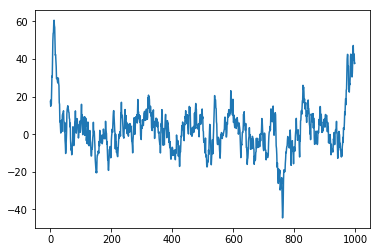

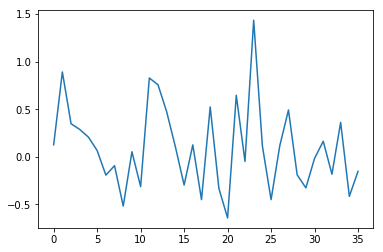

torch.Size([1775, 4])
Train Accuracy: 58 %


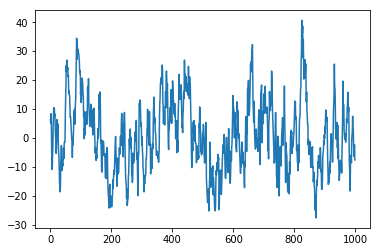

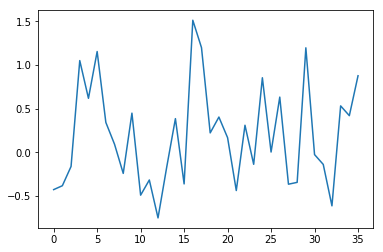

predicted set [0 1 2 3]
label set [0 1 2 3]
validation Accuracy: 43 %
Epoch [7/30], Iter [1/17] Loss: [----- 0.9158 = 0.9158 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [7/30], Iter [2/17] Loss: [----- 1.0597 = 1.0597 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [7/30], Iter [3/17] Loss: [----- 0.9416 = 0.9416 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [7/30], Iter [4/17] Loss: [----- 0.9671 = 0.9671 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [7/30], Iter [5/17] Loss: [----- 1.0170 = 1.0170 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [7/30], Iter [6/17] Loss: [----- 0.9772 = 0.9772 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [7/30], Iter [7/17] Loss: [----- 0.9077 = 0.9077 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [7/30], Iter [8/17] Loss: [----- 1.0248 = 1.0248 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [7/30], Iter [9/17] Loss: [----- 1.0094 = 1.0094 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [7/30], Iter [10/17] Loss: [----- 0.9285 = 0.9285 + 1.00 * 1.6046 + 0

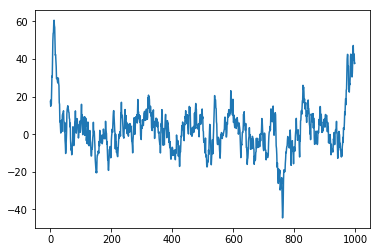

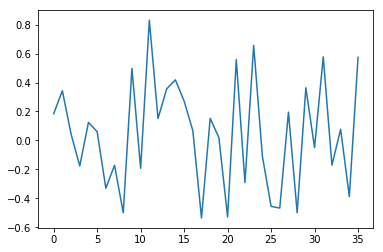

torch.Size([1775, 4])
Train Accuracy: 67 %


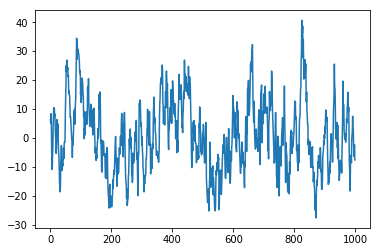

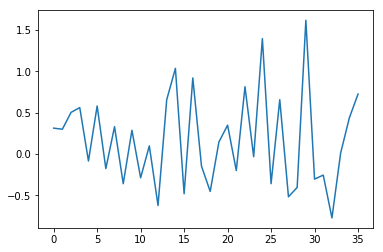

predicted set [0 1 2 3]
label set [0 1 2 3]
validation Accuracy: 46 %
Epoch [8/30], Iter [1/17] Loss: [----- 0.8968 = 0.8968 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [8/30], Iter [2/17] Loss: [----- 0.8709 = 0.8709 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [8/30], Iter [3/17] Loss: [----- 0.8900 = 0.8900 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [8/30], Iter [4/17] Loss: [----- 0.8807 = 0.8807 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [8/30], Iter [5/17] Loss: [----- 0.9069 = 0.9069 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [8/30], Iter [6/17] Loss: [----- 0.9249 = 0.9249 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [8/30], Iter [7/17] Loss: [----- 0.8600 = 0.8600 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [8/30], Iter [8/17] Loss: [----- 0.9537 = 0.9537 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [8/30], Iter [9/17] Loss: [----- 0.8278 = 0.8278 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [8/30], Iter [10/17] Loss: [----- 0.9180 = 0.9180 + 1.00 * 1.6046 + 0

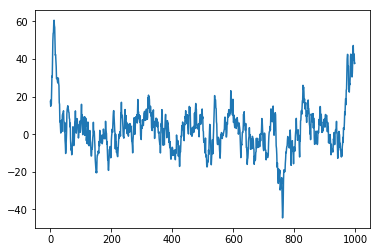

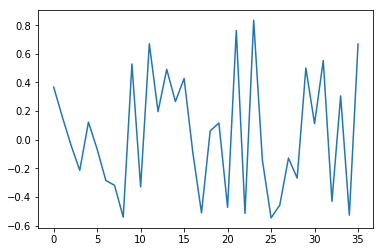

torch.Size([1775, 4])
Train Accuracy: 70 %


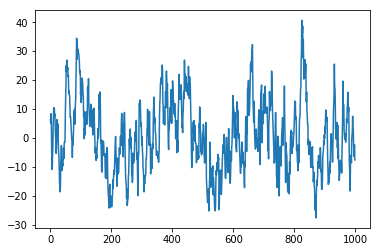

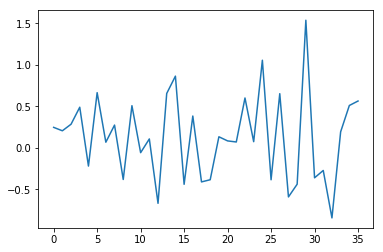

predicted set [0 1 2 3]
label set [0 1 2 3]
validation Accuracy: 52 %
Epoch [9/30], Iter [1/17] Loss: [----- 0.8676 = 0.8676 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [9/30], Iter [2/17] Loss: [----- 0.7949 = 0.7949 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [9/30], Iter [3/17] Loss: [----- 0.9390 = 0.9390 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [9/30], Iter [4/17] Loss: [----- 0.8483 = 0.8483 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [9/30], Iter [5/17] Loss: [----- 0.7995 = 0.7995 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [9/30], Iter [6/17] Loss: [----- 0.8372 = 0.8372 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [9/30], Iter [7/17] Loss: [----- 0.9417 = 0.9417 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [9/30], Iter [8/17] Loss: [----- 0.8575 = 0.8575 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [9/30], Iter [9/17] Loss: [----- 0.7929 = 0.7929 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [9/30], Iter [10/17] Loss: [----- 0.8385 = 0.8385 + 1.00 * 1.6046 + 0

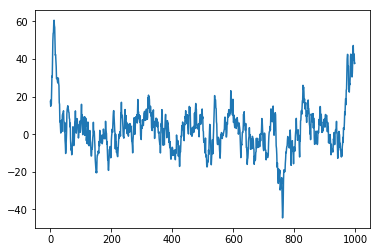

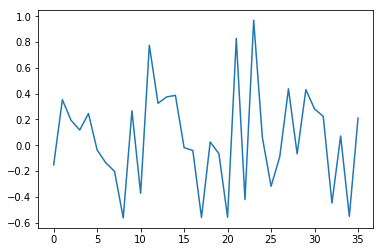

torch.Size([1775, 4])
Train Accuracy: 73 %


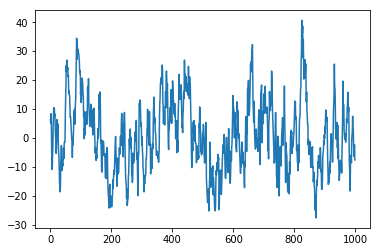

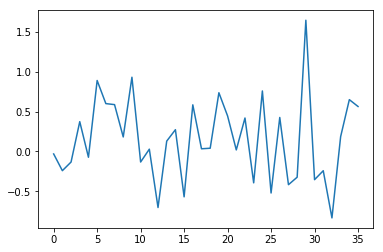

predicted set [0 1 2 3]
label set [0 1 2 3]
validation Accuracy: 50 %
Epoch [10/30], Iter [1/17] Loss: [----- 0.9689 = 0.9689 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [10/30], Iter [2/17] Loss: [----- 0.8124 = 0.8124 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [10/30], Iter [3/17] Loss: [----- 0.7734 = 0.7734 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [10/30], Iter [4/17] Loss: [----- 0.8443 = 0.8443 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [10/30], Iter [5/17] Loss: [----- 0.8189 = 0.8189 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [10/30], Iter [6/17] Loss: [----- 0.8841 = 0.8841 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [10/30], Iter [7/17] Loss: [----- 0.8499 = 0.8499 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [10/30], Iter [8/17] Loss: [----- 0.7580 = 0.7580 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [10/30], Iter [9/17] Loss: [----- 0.7863 = 0.7863 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [10/30], Iter [10/17] Loss: [----- 0.8015 = 0.8015 + 1.00 * 

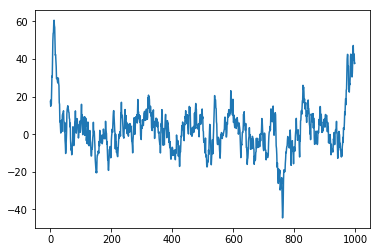

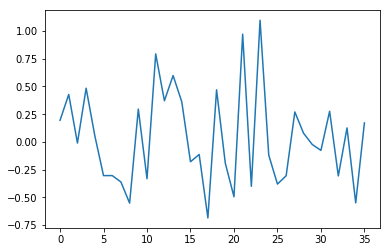

torch.Size([1775, 4])
Train Accuracy: 76 %


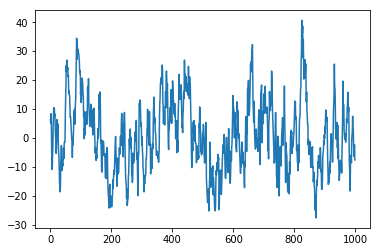

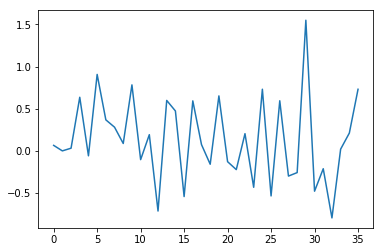

predicted set [0 1 2 3]
label set [0 1 2 3]
validation Accuracy: 54 %
Epoch [11/30], Iter [1/17] Loss: [----- 0.8126 = 0.8126 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [11/30], Iter [2/17] Loss: [----- 0.8320 = 0.8320 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [11/30], Iter [3/17] Loss: [----- 0.7790 = 0.7790 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [11/30], Iter [4/17] Loss: [----- 0.8321 = 0.8321 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [11/30], Iter [5/17] Loss: [----- 0.7711 = 0.7711 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [11/30], Iter [6/17] Loss: [----- 0.6485 = 0.6485 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [11/30], Iter [7/17] Loss: [----- 0.7302 = 0.7302 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [11/30], Iter [8/17] Loss: [----- 0.6539 = 0.6539 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [11/30], Iter [9/17] Loss: [----- 0.7735 = 0.7735 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [11/30], Iter [10/17] Loss: [----- 0.7460 = 0.7460 + 1.00 * 

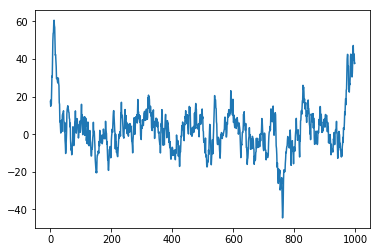

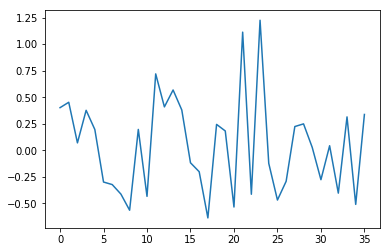

torch.Size([1775, 4])
Train Accuracy: 76 %


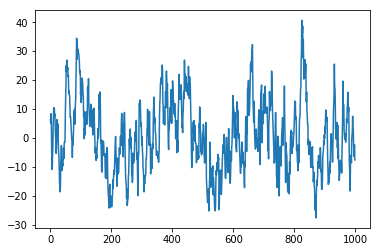

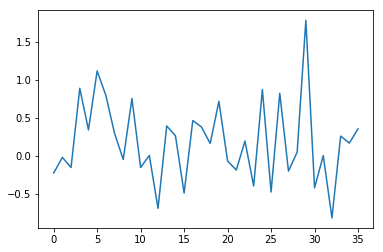

predicted set [0 1 2 3]
label set [0 1 2 3]
validation Accuracy: 54 %
Epoch [12/30], Iter [1/17] Loss: [----- 0.7129 = 0.7129 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [12/30], Iter [2/17] Loss: [----- 0.6604 = 0.6604 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [12/30], Iter [3/17] Loss: [----- 0.6913 = 0.6913 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [12/30], Iter [4/17] Loss: [----- 0.7675 = 0.7675 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [12/30], Iter [5/17] Loss: [----- 0.7825 = 0.7825 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [12/30], Iter [6/17] Loss: [----- 0.6741 = 0.6741 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [12/30], Iter [7/17] Loss: [----- 0.7215 = 0.7215 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [12/30], Iter [8/17] Loss: [----- 0.8579 = 0.8579 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [12/30], Iter [9/17] Loss: [----- 0.7286 = 0.7286 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [12/30], Iter [10/17] Loss: [----- 0.7652 = 0.7652 + 1.00 * 

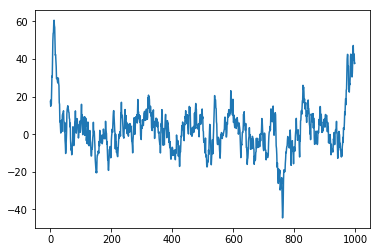

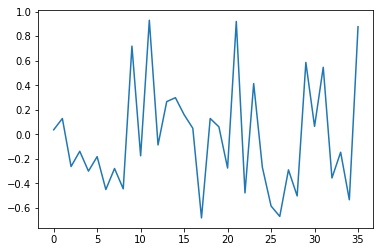

torch.Size([1775, 4])
Train Accuracy: 77 %


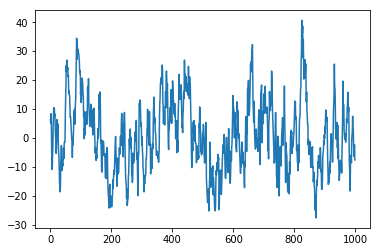

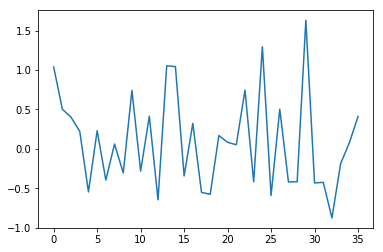

predicted set [0 1 2 3]
label set [0 1 2 3]
validation Accuracy: 53 %
Epoch [13/30], Iter [1/17] Loss: [----- 0.6155 = 0.6155 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [13/30], Iter [2/17] Loss: [----- 0.6242 = 0.6242 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [13/30], Iter [3/17] Loss: [----- 0.6996 = 0.6996 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [13/30], Iter [4/17] Loss: [----- 0.7784 = 0.7784 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [13/30], Iter [5/17] Loss: [----- 0.7124 = 0.7124 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [13/30], Iter [6/17] Loss: [----- 0.6864 = 0.6864 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [13/30], Iter [7/17] Loss: [----- 0.7471 = 0.7471 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [13/30], Iter [8/17] Loss: [----- 0.7066 = 0.7066 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [13/30], Iter [9/17] Loss: [----- 0.6070 = 0.6070 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [13/30], Iter [10/17] Loss: [----- 0.6360 = 0.6360 + 1.00 * 

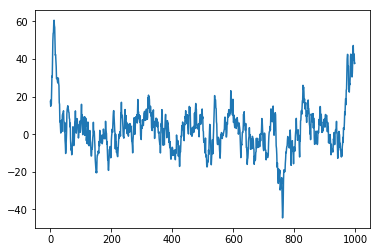

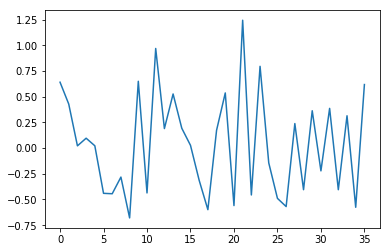

torch.Size([1775, 4])
Train Accuracy: 80 %


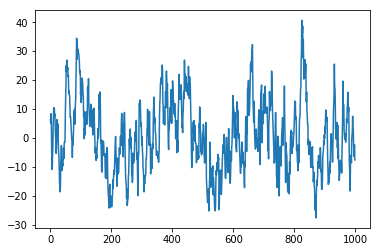

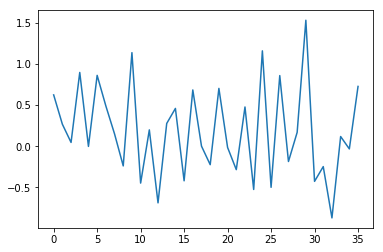

predicted set [0 1 2 3]
label set [0 1 2 3]
validation Accuracy: 52 %
Epoch [14/30], Iter [1/17] Loss: [----- 0.5904 = 0.5904 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [14/30], Iter [2/17] Loss: [----- 0.6225 = 0.6225 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [14/30], Iter [3/17] Loss: [----- 0.5612 = 0.5612 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [14/30], Iter [4/17] Loss: [----- 0.6393 = 0.6393 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [14/30], Iter [5/17] Loss: [----- 0.6782 = 0.6782 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [14/30], Iter [6/17] Loss: [----- 0.6652 = 0.6652 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [14/30], Iter [7/17] Loss: [----- 0.5555 = 0.5555 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [14/30], Iter [8/17] Loss: [----- 0.7256 = 0.7256 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [14/30], Iter [9/17] Loss: [----- 0.6405 = 0.6405 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [14/30], Iter [10/17] Loss: [----- 0.7265 = 0.7265 + 1.00 * 

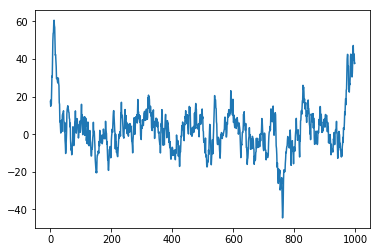

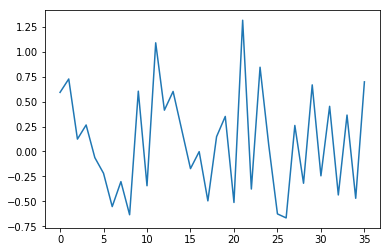

torch.Size([1775, 4])
Train Accuracy: 80 %


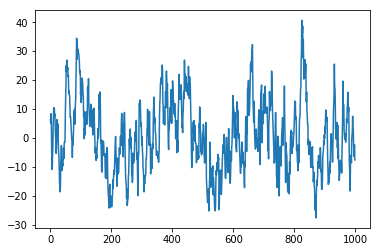

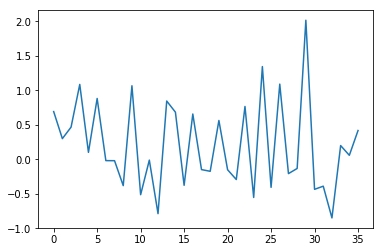

predicted set [0 1 2 3]
label set [0 1 2 3]
validation Accuracy: 52 %
Epoch [15/30], Iter [1/17] Loss: [----- 0.5174 = 0.5174 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [15/30], Iter [2/17] Loss: [----- 0.6501 = 0.6501 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [15/30], Iter [3/17] Loss: [----- 0.5310 = 0.5310 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [15/30], Iter [4/17] Loss: [----- 0.5700 = 0.5700 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [15/30], Iter [5/17] Loss: [----- 0.5888 = 0.5888 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [15/30], Iter [6/17] Loss: [----- 0.7110 = 0.7110 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [15/30], Iter [7/17] Loss: [----- 0.5894 = 0.5894 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [15/30], Iter [8/17] Loss: [----- 0.5865 = 0.5865 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [15/30], Iter [9/17] Loss: [----- 0.6598 = 0.6598 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [15/30], Iter [10/17] Loss: [----- 0.5879 = 0.5879 + 1.00 * 

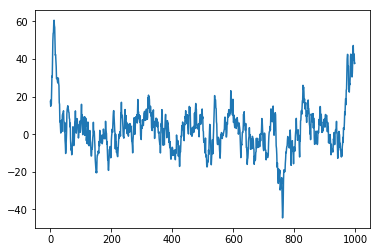

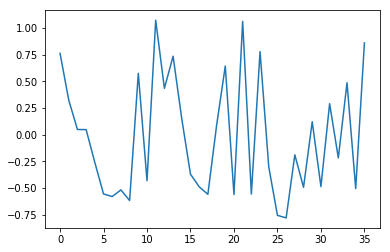

torch.Size([1775, 4])
Train Accuracy: 81 %


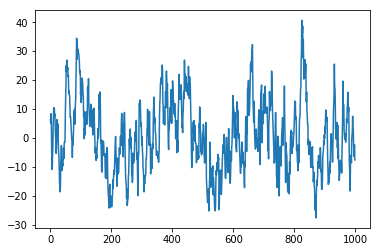

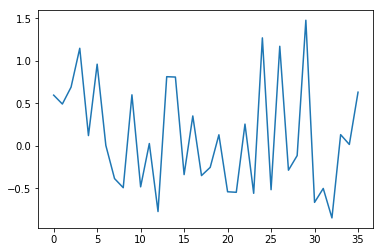

predicted set [0 1 2 3]
label set [0 1 2 3]
validation Accuracy: 51 %
Epoch [16/30], Iter [1/17] Loss: [----- 0.6051 = 0.6051 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [16/30], Iter [2/17] Loss: [----- 0.5479 = 0.5479 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [16/30], Iter [3/17] Loss: [----- 0.6314 = 0.6314 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [16/30], Iter [4/17] Loss: [----- 0.5726 = 0.5726 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [16/30], Iter [5/17] Loss: [----- 0.5231 = 0.5231 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [16/30], Iter [6/17] Loss: [----- 0.5794 = 0.5794 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [16/30], Iter [7/17] Loss: [----- 0.6562 = 0.6562 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [16/30], Iter [8/17] Loss: [----- 0.5900 = 0.5900 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [16/30], Iter [9/17] Loss: [----- 0.5388 = 0.5388 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [16/30], Iter [10/17] Loss: [----- 0.5839 = 0.5839 + 1.00 * 

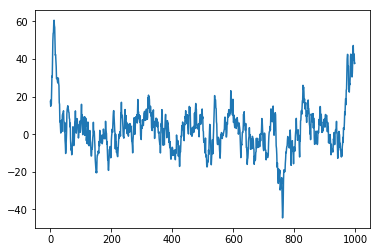

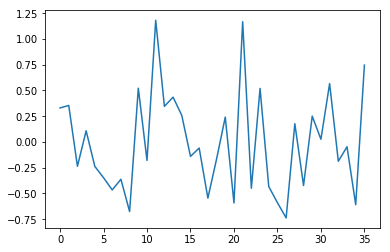

torch.Size([1775, 4])
Train Accuracy: 85 %


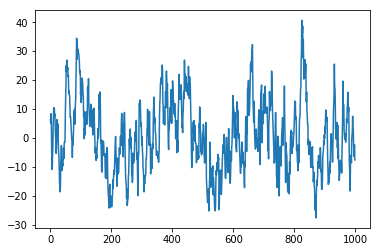

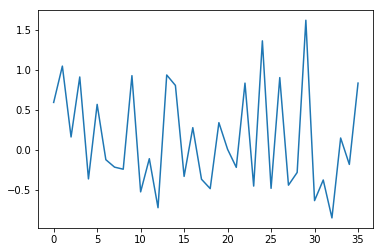

predicted set [0 1 2 3]
label set [0 1 2 3]
validation Accuracy: 54 %
Epoch [17/30], Iter [1/17] Loss: [----- 0.5472 = 0.5472 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [17/30], Iter [2/17] Loss: [----- 0.4913 = 0.4913 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [17/30], Iter [3/17] Loss: [----- 0.5175 = 0.5175 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [17/30], Iter [4/17] Loss: [----- 0.5776 = 0.5776 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [17/30], Iter [5/17] Loss: [----- 0.5442 = 0.5442 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [17/30], Iter [6/17] Loss: [----- 0.5688 = 0.5688 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [17/30], Iter [7/17] Loss: [----- 0.5416 = 0.5416 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [17/30], Iter [8/17] Loss: [----- 0.5208 = 0.5208 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [17/30], Iter [9/17] Loss: [----- 0.5272 = 0.5272 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [17/30], Iter [10/17] Loss: [----- 0.5780 = 0.5780 + 1.00 * 

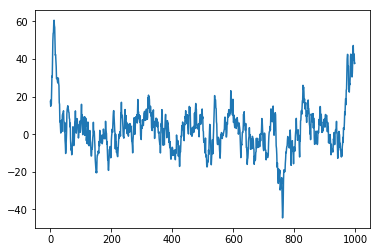

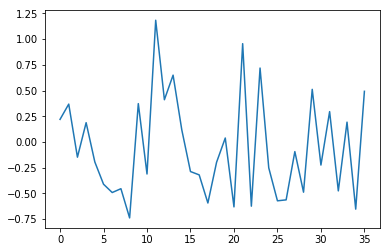

torch.Size([1775, 4])
Train Accuracy: 84 %


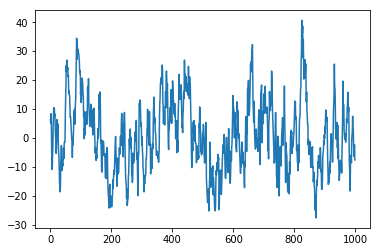

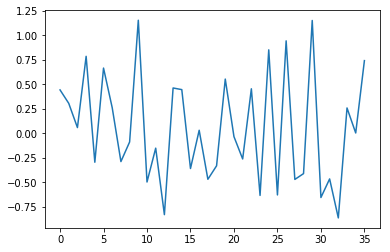

predicted set [0 1 2 3]
label set [0 1 2 3]
validation Accuracy: 50 %
Epoch [18/30], Iter [1/17] Loss: [----- 0.5249 = 0.5249 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [18/30], Iter [2/17] Loss: [----- 0.4512 = 0.4512 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [18/30], Iter [3/17] Loss: [----- 0.5361 = 0.5361 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [18/30], Iter [4/17] Loss: [----- 0.5066 = 0.5066 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [18/30], Iter [5/17] Loss: [----- 0.4881 = 0.4881 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [18/30], Iter [6/17] Loss: [----- 0.5406 = 0.5406 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [18/30], Iter [7/17] Loss: [----- 0.5170 = 0.5170 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [18/30], Iter [8/17] Loss: [----- 0.4846 = 0.4846 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [18/30], Iter [9/17] Loss: [----- 0.3969 = 0.3969 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [18/30], Iter [10/17] Loss: [----- 0.5415 = 0.5415 + 1.00 * 

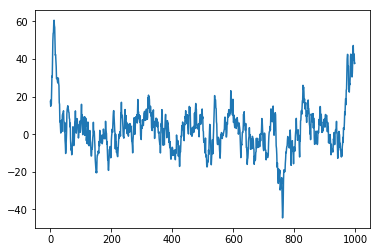

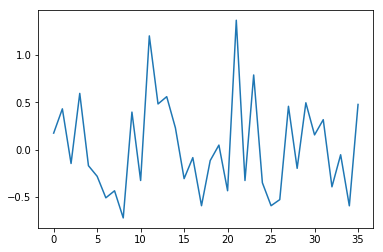

torch.Size([1775, 4])
Train Accuracy: 88 %


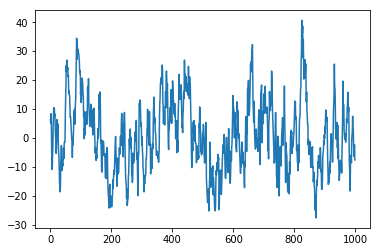

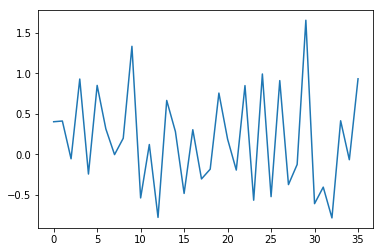

predicted set [0 1 2 3]
label set [0 1 2 3]
validation Accuracy: 55 %
Epoch [19/30], Iter [1/17] Loss: [----- 0.4338 = 0.4338 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [19/30], Iter [2/17] Loss: [----- 0.3729 = 0.3729 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [19/30], Iter [3/17] Loss: [----- 0.4487 = 0.4487 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [19/30], Iter [4/17] Loss: [----- 0.4512 = 0.4512 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [19/30], Iter [5/17] Loss: [----- 0.4480 = 0.4480 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [19/30], Iter [6/17] Loss: [----- 0.5206 = 0.5206 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [19/30], Iter [7/17] Loss: [----- 0.5151 = 0.5151 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [19/30], Iter [8/17] Loss: [----- 0.5173 = 0.5173 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [19/30], Iter [9/17] Loss: [----- 0.4789 = 0.4789 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [19/30], Iter [10/17] Loss: [----- 0.4364 = 0.4364 + 1.00 * 

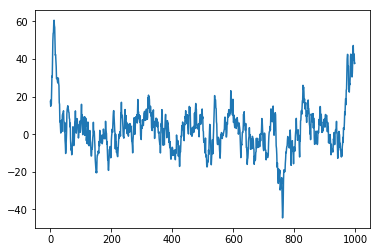

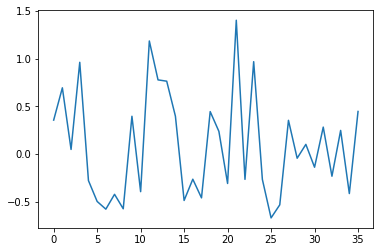

torch.Size([1775, 4])
Train Accuracy: 88 %


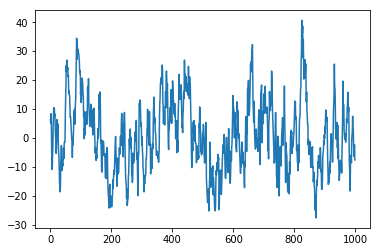

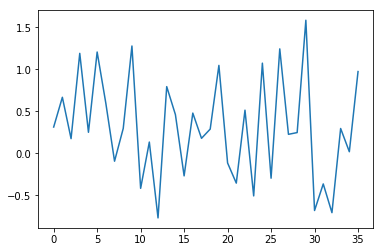

predicted set [0 1 2 3]
label set [0 1 2 3]
validation Accuracy: 53 %
Epoch [20/30], Iter [1/17] Loss: [----- 0.3559 = 0.3559 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [20/30], Iter [2/17] Loss: [----- 0.4372 = 0.4372 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [20/30], Iter [3/17] Loss: [----- 0.4132 = 0.4132 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [20/30], Iter [4/17] Loss: [----- 0.5401 = 0.5401 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [20/30], Iter [5/17] Loss: [----- 0.3854 = 0.3854 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [20/30], Iter [6/17] Loss: [----- 0.4940 = 0.4940 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [20/30], Iter [7/17] Loss: [----- 0.4725 = 0.4725 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [20/30], Iter [8/17] Loss: [----- 0.4146 = 0.4146 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [20/30], Iter [9/17] Loss: [----- 0.5490 = 0.5490 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [20/30], Iter [10/17] Loss: [----- 0.4048 = 0.4048 + 1.00 * 

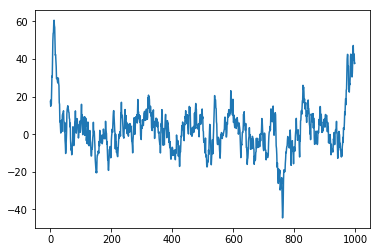

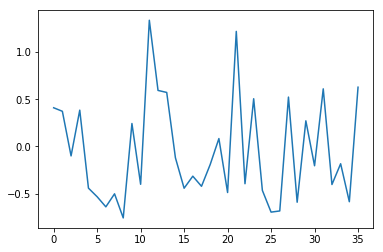

torch.Size([1775, 4])
Train Accuracy: 87 %


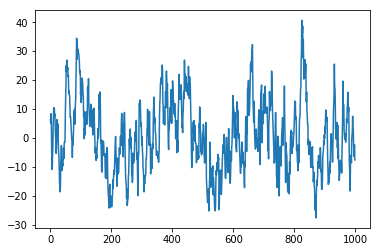

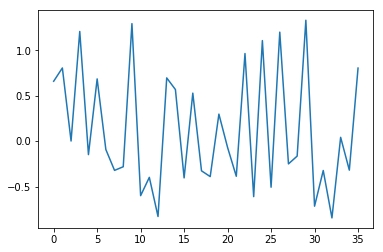

predicted set [0 1 2 3]
label set [0 1 2 3]
validation Accuracy: 54 %
Epoch [21/30], Iter [1/17] Loss: [----- 0.3520 = 0.3520 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [21/30], Iter [2/17] Loss: [----- 0.4475 = 0.4475 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [21/30], Iter [3/17] Loss: [----- 0.3974 = 0.3974 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [21/30], Iter [4/17] Loss: [----- 0.4866 = 0.4866 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [21/30], Iter [5/17] Loss: [----- 0.4849 = 0.4849 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [21/30], Iter [6/17] Loss: [----- 0.4834 = 0.4834 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [21/30], Iter [7/17] Loss: [----- 0.4137 = 0.4137 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [21/30], Iter [8/17] Loss: [----- 0.3960 = 0.3960 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [21/30], Iter [9/17] Loss: [----- 0.4925 = 0.4925 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [21/30], Iter [10/17] Loss: [----- 0.4743 = 0.4743 + 1.00 * 

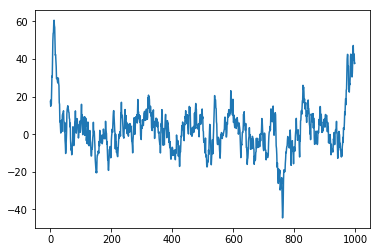

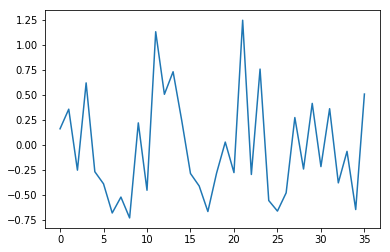

torch.Size([1775, 4])
Train Accuracy: 90 %


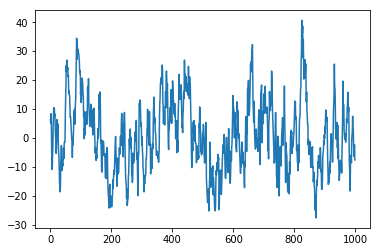

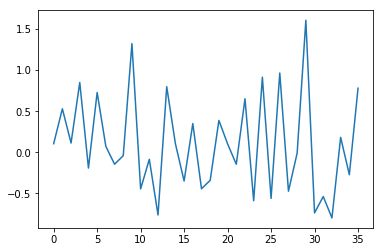

predicted set [0 1 2 3]
label set [0 1 2 3]
validation Accuracy: 56 %
Epoch [22/30], Iter [1/17] Loss: [----- 0.3858 = 0.3858 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [22/30], Iter [2/17] Loss: [----- 0.3350 = 0.3350 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [22/30], Iter [3/17] Loss: [----- 0.3425 = 0.3425 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [22/30], Iter [4/17] Loss: [----- 0.4032 = 0.4032 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [22/30], Iter [5/17] Loss: [----- 0.3588 = 0.3588 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [22/30], Iter [6/17] Loss: [----- 0.3614 = 0.3614 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [22/30], Iter [7/17] Loss: [----- 0.3208 = 0.3208 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [22/30], Iter [8/17] Loss: [----- 0.4446 = 0.4446 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [22/30], Iter [9/17] Loss: [----- 0.4322 = 0.4322 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [22/30], Iter [10/17] Loss: [----- 0.4149 = 0.4149 + 1.00 * 

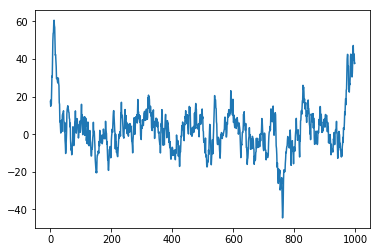

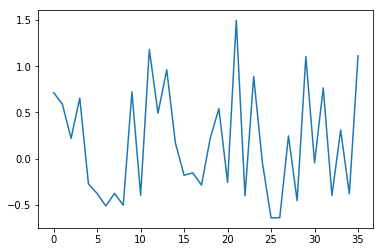

torch.Size([1775, 4])
Train Accuracy: 92 %


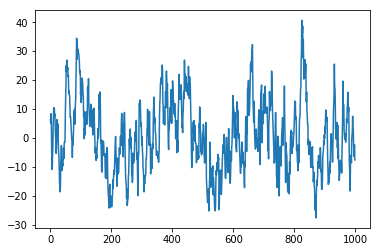

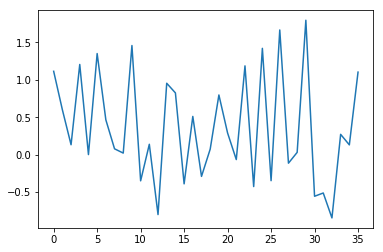

predicted set [0 1 2 3]
label set [0 1 2 3]
validation Accuracy: 54 %
Epoch [23/30], Iter [1/17] Loss: [----- 0.3304 = 0.3304 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [23/30], Iter [2/17] Loss: [----- 0.3247 = 0.3247 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [23/30], Iter [3/17] Loss: [----- 0.3856 = 0.3856 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [23/30], Iter [4/17] Loss: [----- 0.3027 = 0.3027 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [23/30], Iter [5/17] Loss: [----- 0.3919 = 0.3919 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [23/30], Iter [6/17] Loss: [----- 0.4000 = 0.4000 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [23/30], Iter [7/17] Loss: [----- 0.3556 = 0.3556 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [23/30], Iter [8/17] Loss: [----- 0.3530 = 0.3530 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [23/30], Iter [9/17] Loss: [----- 0.3447 = 0.3447 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [23/30], Iter [10/17] Loss: [----- 0.4676 = 0.4676 + 1.00 * 

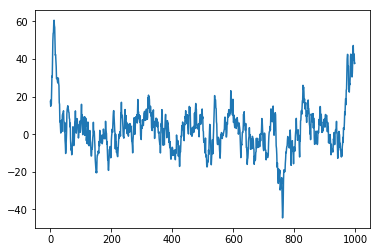

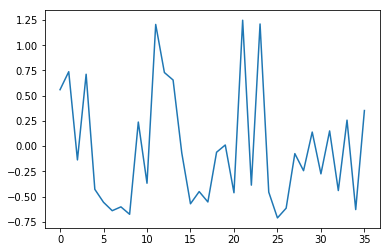

torch.Size([1775, 4])
Train Accuracy: 92 %


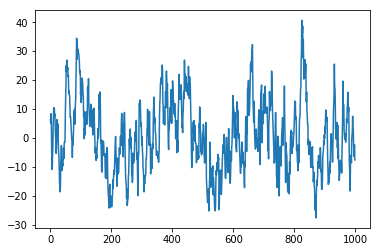

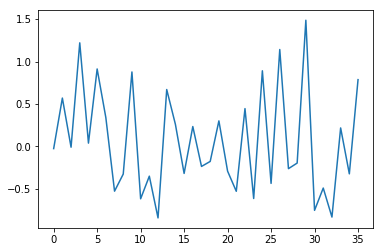

predicted set [0 1 2 3]
label set [0 1 2 3]
validation Accuracy: 54 %
Epoch [24/30], Iter [1/17] Loss: [----- 0.3059 = 0.3059 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [24/30], Iter [2/17] Loss: [----- 0.3829 = 0.3829 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [24/30], Iter [3/17] Loss: [----- 0.3863 = 0.3863 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [24/30], Iter [4/17] Loss: [----- 0.2972 = 0.2972 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [24/30], Iter [5/17] Loss: [----- 0.2872 = 0.2872 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [24/30], Iter [6/17] Loss: [----- 0.4645 = 0.4645 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [24/30], Iter [7/17] Loss: [----- 0.2911 = 0.2911 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [24/30], Iter [8/17] Loss: [----- 0.3714 = 0.3714 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [24/30], Iter [9/17] Loss: [----- 0.3501 = 0.3501 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [24/30], Iter [10/17] Loss: [----- 0.4207 = 0.4207 + 1.00 * 

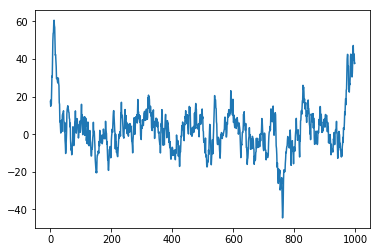

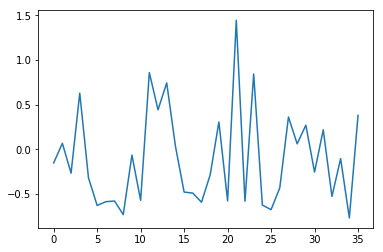

torch.Size([1775, 4])
Train Accuracy: 93 %


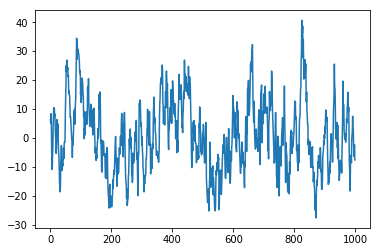

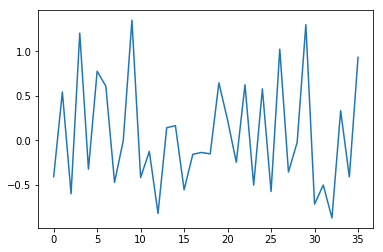

predicted set [0 1 2 3]
label set [0 1 2 3]
validation Accuracy: 55 %
Epoch [25/30], Iter [1/17] Loss: [----- 0.3002 = 0.3002 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [25/30], Iter [2/17] Loss: [----- 0.4524 = 0.4524 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [25/30], Iter [3/17] Loss: [----- 0.3138 = 0.3138 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [25/30], Iter [4/17] Loss: [----- 0.3125 = 0.3125 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [25/30], Iter [5/17] Loss: [----- 0.3169 = 0.3169 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [25/30], Iter [6/17] Loss: [----- 0.3386 = 0.3386 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [25/30], Iter [7/17] Loss: [----- 0.3173 = 0.3173 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [25/30], Iter [8/17] Loss: [----- 0.2680 = 0.2680 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [25/30], Iter [9/17] Loss: [----- 0.2763 = 0.2763 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [25/30], Iter [10/17] Loss: [----- 0.3927 = 0.3927 + 1.00 * 

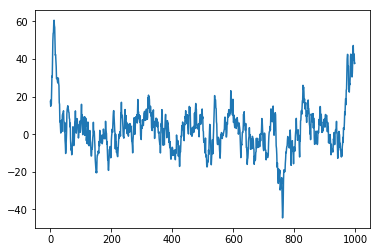

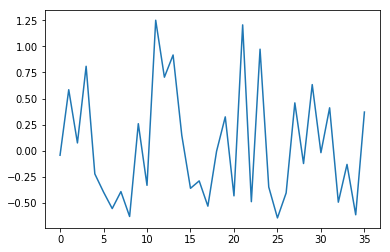

torch.Size([1775, 4])
Train Accuracy: 93 %


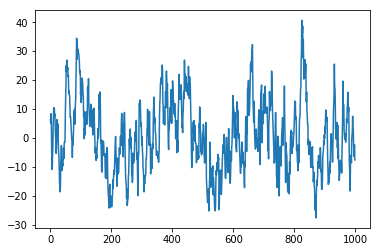

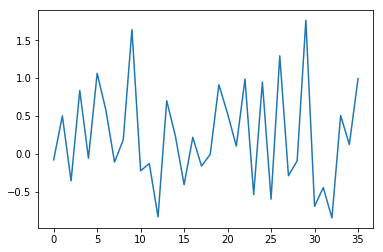

predicted set [0 1 2 3]
label set [0 1 2 3]
validation Accuracy: 53 %
Epoch [26/30], Iter [1/17] Loss: [----- 0.3179 = 0.3179 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [26/30], Iter [2/17] Loss: [----- 0.2907 = 0.2907 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [26/30], Iter [3/17] Loss: [----- 0.2779 = 0.2779 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [26/30], Iter [4/17] Loss: [----- 0.2912 = 0.2912 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [26/30], Iter [5/17] Loss: [----- 0.2625 = 0.2625 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [26/30], Iter [6/17] Loss: [----- 0.2749 = 0.2749 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [26/30], Iter [7/17] Loss: [----- 0.3130 = 0.3130 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [26/30], Iter [8/17] Loss: [----- 0.3562 = 0.3562 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [26/30], Iter [9/17] Loss: [----- 0.2893 = 0.2893 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [26/30], Iter [10/17] Loss: [----- 0.3225 = 0.3225 + 1.00 * 

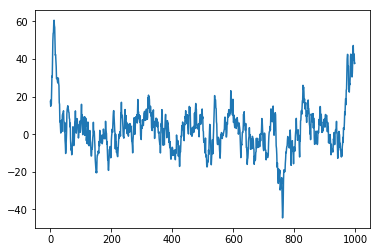

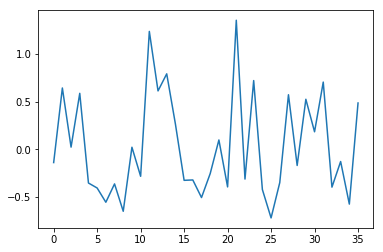

torch.Size([1775, 4])
Train Accuracy: 95 %


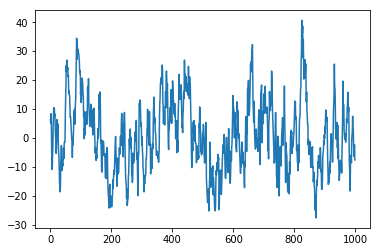

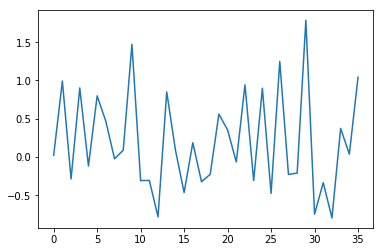

predicted set [0 1 2 3]
label set [0 1 2 3]
validation Accuracy: 54 %
Epoch [27/30], Iter [1/17] Loss: [----- 0.2592 = 0.2592 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [27/30], Iter [2/17] Loss: [----- 0.2505 = 0.2505 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [27/30], Iter [3/17] Loss: [----- 0.2283 = 0.2283 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [27/30], Iter [4/17] Loss: [----- 0.2948 = 0.2948 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [27/30], Iter [5/17] Loss: [----- 0.2907 = 0.2907 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [27/30], Iter [6/17] Loss: [----- 0.2866 = 0.2866 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [27/30], Iter [7/17] Loss: [----- 0.3144 = 0.3144 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [27/30], Iter [8/17] Loss: [----- 0.3314 = 0.3314 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [27/30], Iter [9/17] Loss: [----- 0.2950 = 0.2950 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [27/30], Iter [10/17] Loss: [----- 0.2509 = 0.2509 + 1.00 * 

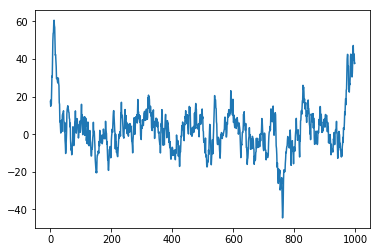

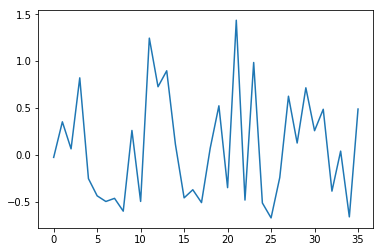

torch.Size([1775, 4])
Train Accuracy: 95 %


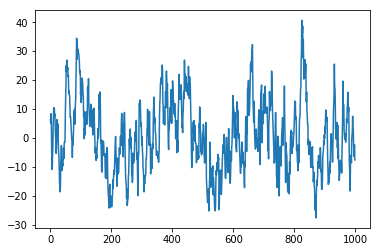

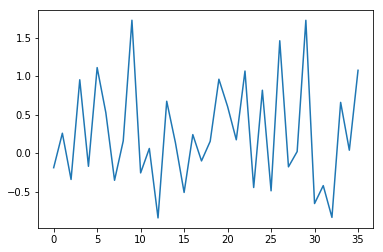

predicted set [0 1 2 3]
label set [0 1 2 3]
validation Accuracy: 52 %
Epoch [28/30], Iter [1/17] Loss: [----- 0.2738 = 0.2738 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [28/30], Iter [2/17] Loss: [----- 0.2538 = 0.2538 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [28/30], Iter [3/17] Loss: [----- 0.2410 = 0.2410 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [28/30], Iter [4/17] Loss: [----- 0.2708 = 0.2708 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [28/30], Iter [5/17] Loss: [----- 0.2870 = 0.2870 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [28/30], Iter [6/17] Loss: [----- 0.2368 = 0.2368 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [28/30], Iter [7/17] Loss: [----- 0.2698 = 0.2698 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [28/30], Iter [8/17] Loss: [----- 0.2388 = 0.2388 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [28/30], Iter [9/17] Loss: [----- 0.2641 = 0.2641 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [28/30], Iter [10/17] Loss: [----- 0.2841 = 0.2841 + 1.00 * 

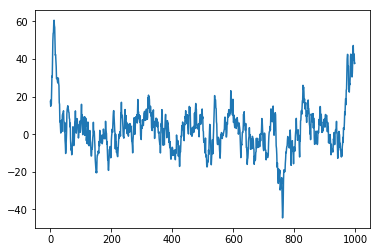

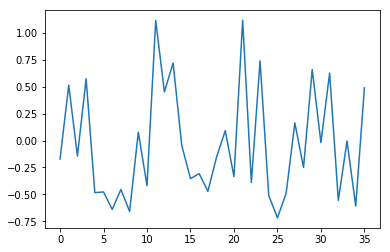

torch.Size([1775, 4])
Train Accuracy: 97 %


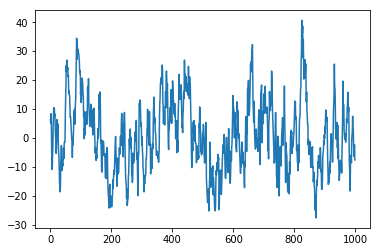

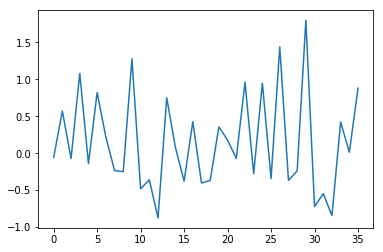

predicted set [0 1 2 3]
label set [0 1 2 3]
validation Accuracy: 55 %
Epoch [29/30], Iter [1/17] Loss: [----- 0.2308 = 0.2308 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [29/30], Iter [2/17] Loss: [----- 0.2505 = 0.2505 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [29/30], Iter [3/17] Loss: [----- 0.2005 = 0.2005 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [29/30], Iter [4/17] Loss: [----- 0.2185 = 0.2185 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [29/30], Iter [5/17] Loss: [----- 0.2654 = 0.2654 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [29/30], Iter [6/17] Loss: [----- 0.2426 = 0.2426 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [29/30], Iter [7/17] Loss: [----- 0.2476 = 0.2476 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [29/30], Iter [8/17] Loss: [----- 0.2353 = 0.2353 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [29/30], Iter [9/17] Loss: [----- 0.2591 = 0.2591 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [29/30], Iter [10/17] Loss: [----- 0.2547 = 0.2547 + 1.00 * 

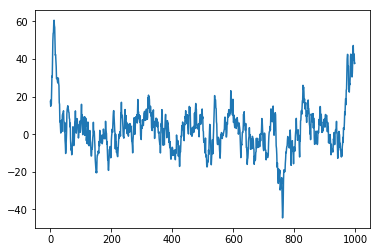

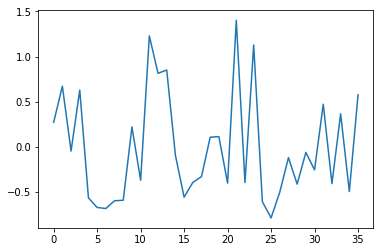

torch.Size([1775, 4])
Train Accuracy: 93 %


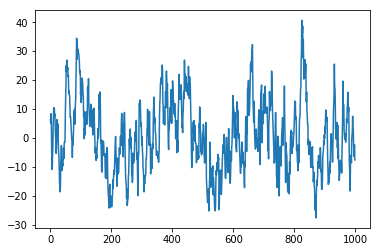

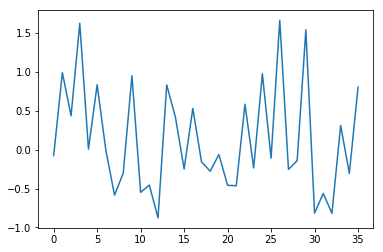

predicted set [0 1 2 3]
label set [0 1 2 3]
validation Accuracy: 51 %
Epoch [30/30], Iter [1/17] Loss: [----- 0.2557 = 0.2557 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [30/30], Iter [2/17] Loss: [----- 0.2425 = 0.2425 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [30/30], Iter [3/17] Loss: [----- 0.3184 = 0.3184 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]


In [ ]:
import gc
gc.collect()

torch.manual_seed(1111)

train_acc = []
val_acc = []
loss_history = []
          
for epoch in range(num_epochs):

    ######################## TRAINING
        
    net.train(True)
    
    for i, (images, labels) in enumerate(train_loader):
        
        images = Variable(images, requires_grad=True) #unsqueeze used to make a 4d tensor because 
        
        if (VERBOSE):
            print('initial label shape: {}'.format(labels.shape))
            
        labels = Variable(labels)

        if (VERBOSE):
            print('iteration label set {}'.format(np.unique(labels.data)))
        
        # Forward + Backward + Optimize
        optimizer.zero_grad()
        
        if (FCC_SANITY):
            outputs = net(images)
        else:    
            outputs, hidden = net(images)

        _, predicted = torch.max(outputs.data, 1)
    
        if (VERBOSE):
            print('training predicted set {}'.format(np.unique(predicted.data)))
            print('training output shape: {}'.format(outputs.shape))
            print('training labels shape: {}'.format(labels.shape))
        
        loss1 = criterion(outputs, labels)
        loss1.backward(retain_graph=True)
        
        ## hidden state vanishing gradient regularizer
        #hidden_loss, size_loss = net.loss_regularizer()
        
        ## general weight l2 regularizer()
        
        loss = loss1 #+ reg_hidden_weight*hidden_loss + reg_weight_size*size_loss

        #loss = criterion(outputs, labels)

        loss_history.append(loss)
        loss.backward()
        
        nn.utils.clip_grad_norm(net.parameters(), 100)
        optimizer.step()
        
        print ('Epoch [%d/%d], Iter [%d/%d] Loss: [----- %.4f = %.4f + %.2f * %.4f + %.2f * %.4f -----]' 
               %(epoch+1, num_epochs, i+1, rnn_training_data_X.shape[0]*1.0/batch_size,
                 loss.data[0], loss1.data[0],
                 reg_hidden_weight, hidden_loss.data[0],
                 reg_weight_size, size_loss.data[0]))
    
    ######################## PER EPOCH EVALUATION
            
    bad_grads = []
    for n,p in net.named_parameters():
        grad_max = torch.max(p.grad)
        abs_grad_mean = torch.mean(torch.abs(p.grad))
        if (PRINT_GRADS):
            print('===========\ngradient:{}'.format(n))
            print('---------\nmax: {}, mean: {}'.format(grad_max, abs_grad_mean))
            
        stats = [n, grad_max, abs_grad_mean]
        
        if (abs_grad_mean < 1e-4):
            stats.append('SMALL')
            bad_grads.append(stats)
        elif (1 < abs_grad_mean):
            stats.append('BIG')
            bad_grads.append(stats)
            
    for n, grad_max, abs_grad_mean, descr in bad_grads:
        print('===========\n {} gradient:{}'.format(descr, n))
        print('---------\nmax: {}, mean: {}'.format(grad_max, abs_grad_mean))  
        
    if (VERBOSE):
        print('weight_hh_l0:')
        print(net.rnn_layer.state_dict()['weight_hh_l0'])

    
    net.train(False)
    
    images = Variable(torch.Tensor(rnn_training_data_X))
    test_labels = torch.LongTensor(rnn_training_data_Y)
    
    if (FCC_SANITY):
        outputs = net(images)
    else:
        outputs, hidden = net(images)
    
    print(outputs.shape)
    
    correct = 0
    total = 0
    _, predicted = torch.max(outputs.data, 1)
    total += test_labels.size(0)
    correct += (predicted == test_labels).double().sum()
    print('Train Accuracy: %d %%' % (100 * int(correct) / float(total)))
    train_acc.append((100 * correct / total))

    net.eval()  # Change model to 'eval' mode (BN uses moving mean/var).
    correct = 0
    total = 0
    images = Variable(torch.Tensor(rnn_validation_data_X))
    test_labels = torch.LongTensor(rnn_validation_data_Y)
    
    if (FCC_SANITY):
        outputs = net(images)
    else:
        outputs, hidden = net(images)
    
    _, predicted = torch.max(outputs.data, 1)
    
    print('predicted set {}'.format(np.unique(predicted.data)))
    print('label set {}'.format(np.unique(test_labels.data)))
    
    total += test_labels.size(0)
    correct += (predicted == test_labels).double().sum()
    print('validation Accuracy: %d %%' % (100.0 * int(correct) / float(total)))
    val_acc.append((100 * correct / total))

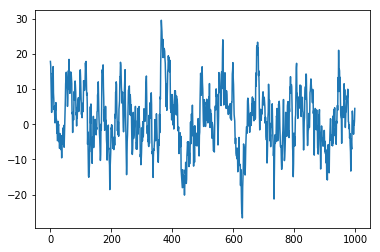

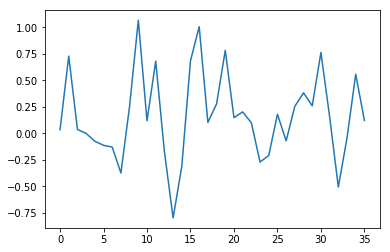

Test Accuracy of the model on the 10000 test images: 45 %


In [112]:

# Test the Model
net.eval()  # Change model to 'eval' mode (BN uses moving mean/var).
correct = 0
total = 0
images = Variable(torch.Tensor(rnn_test_data_X))
labels = torch.LongTensor(rnn_test_data_Y)
outputs = net(images)
_, predicted = torch.max(outputs.data, 1)
total += labels.size(0)
correct += (predicted == labels).sum()

print('Test Accuracy of the model on the 10000 test images: %d %%' % (100.0 * int(correct) / float(total)))

In [ ]:
l = list(net.layer1.modules())
print(l[1].running_mean)
print(l[1].running_var)